# G-Commutative S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [3]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [4]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [5]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

# Dataset Setup and G-Commutative Model Configuration

# dSprites

In [6]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


# G-Commutative VAE Implementation

This notebook implements and tests the **G-Commutative S-N-VAE** model with Group Theory constraints. The G-Commutative VAE extends the standard S-N-VAE by adding commutative constraints that enforce structured relationships in the latent space.

## Model Architecture
- **Base Model**: S-N-VAE with Locatello encoder/decoder architecture
- **Latent Space**: Mixed topology with ['S1', 'R1', 'R1'] factors
- **Group Theory Extensions**: Commutative constraints enforcing g∘g' = g'∘g

## Key Features
- 🔄 **Commutative Constraints**: Enforces commutativity properties in latent transformations
- 📈 **Progressive Training**: Gradual increase of constraint strength with warm-up period
- 🎯 **Group Actions**: Supports R¹ (translation) and S¹ (rotation) transformations
- ⚖️ **Balanced Loss**: Combines reconstruction loss with group theory constraints

## Training Strategy
- **Warm-up Phase**: Initial 5000 steps focus on reconstruction to stabilize training
- **Progressive Weighting**: Commutative loss weight increases from 0.05 to 10.0 over training
- **Deterministic Training**: Fixed seed for reproducible results

# G-Commutative Hyperparameters

In [7]:
#### G-Commutative Loss Configuration ####
# DESIGN PHILOSOPHY: Keep ALL basic training settings identical to standard S-N-VAE
# The ONLY difference is the addition of group theory constraints on top of the base loss

# FIXED: Use correct loss name for S-N-VAE group theory
g_commutative_loss_name = 'group_theory_snvae'  # S-N-VAE compatible group theory loss

# Base loss configuration - use EXACT same settings as standard S-N-VAE
base_loss_g_commutative = {
    'name': 'beta_s_n_vae',
    'kwargs': loss_kwargs_dsprites  # Identical to standard S-N-VAE settings
}

# Group Theory Loss Parameters for G-Commutative
loss_kwargs_g_commutative = {
    'base_loss_name': base_loss_g_commutative['name'],
    'base_loss_kwargs': base_loss_g_commutative['kwargs'],
    'latent_factor_topologies': latent_factor_topologies,
    'device': device,  # FIXED: Required parameter
    
    # KEEP IDENTICAL: Same reconstruction distribution as standard S-N-VAE
    'rec_dist': 'bernoulli',  # Same as standard S-N-VAE for fair comparison
    
    ### ADDED GROUP THEORY CONSTRAINTS (only difference) ###
    'commutative_weight': 1.0,                    # Enable commutative loss
    'commutative_component_order': 2,             # Use pairs for commutative operations
    'commutative_comparison_dist': 'gaussian',    # Comparison metric for commutative constraints
    
    ### Meaningful settings (disabled for pure g-commutative) ###
    'meaningful_weight': 0.0,                     # Disable meaningful loss for pure commutative
    'meaningful_component_order': 1,
    'meaningful_transformation_order': 1,
    'meaningful_critic_gradient_penalty_weight': 10.0,  # FIXED: Required parameter (even if not used)
    'meaningful_critic_lr': 1e-4,                 # FIXED: Required parameter (even if not used)
    'meaningful_n_critic': 1,
    
    ### Group theory general settings ###
    'deterministic_rep': True,                    # Use deterministic representations  
    'g_action_r1_range': 2.0,                    # Range for R1 (translation) actions
    'g_action_s1_range': 2 * torch.pi,           # Full rotation range for S1 actions
    'g_action_r1_dist': 'uniform',               # Distribution for R1 action sampling
    'g_action_s1_dist': 'uniform',               # Distribution for S1 action sampling
    'comp_latent_select_threshold': 0.1,         # Threshold for selecting latent components
    'warm_up_steps': 5000,                       # Warm-up steps before applying group losses
    
    ### Learning rate scheduling ###
    'schedulers_kwargs': [
        {
            'name': 'linear',
            'kwargs': {
                'param_name': 'commutative_weight',
                'initial_value': 0.05,           # Start with low commutative weight
                'final_value': 1.0,             # Gradually increase to strong constraint
                'before_start_value': 0,
                'start_step': 5000,              # Start scheduling after warm-up
                'total_steps': 192000 - 5000  # Schedule over remaining training steps
            }
        }
    ]
}

print("=== TRAINING SETTINGS COMPARISON ===")
print("Standard S-N-VAE vs G-Commutative S-N-VAE:")
print(f"✓ Model architecture: IDENTICAL ({model_name})")
print(f"✓ Decoder output dist: IDENTICAL ({model_decoder_output_dist})")
print(f"✓ Latent topologies: IDENTICAL ({latent_factor_topologies})")
print(f"✓ Learning rate: IDENTICAL ({learning_rate})")
print(f"✓ Batch size: IDENTICAL ({batch_size})")
print(f"✓ Training steps: IDENTICAL ({num_train_steps} {train_step_unit}s)")
print(f"✓ Base loss: IDENTICAL ({base_loss_g_commutative['name']} with bernoulli)")
print(f"✓ Base loss params: IDENTICAL (beta={loss_kwargs_dsprites['beta']})")
print(f"+ ADDITIONAL: Group theory commutative constraints (weight={loss_kwargs_g_commutative['commutative_weight']})")
print(f"+ ADDITIONAL: Warm-up period ({loss_kwargs_g_commutative['warm_up_steps']} steps)")
print(f"🔧 FIXED: Using correct loss name '{g_commutative_loss_name}' for S-N-VAE")
print("\n→ This ensures fair comparison: same base training + group constraints")

=== TRAINING SETTINGS COMPARISON ===
Standard S-N-VAE vs G-Commutative S-N-VAE:
✓ Model architecture: IDENTICAL (s_n_vae_locatello)
✓ Decoder output dist: IDENTICAL (bernoulli)
✓ Latent topologies: IDENTICAL (['S1', 'R1', 'R1'])
✓ Learning rate: IDENTICAL (0.0001)
✓ Batch size: IDENTICAL (64)
✓ Training steps: IDENTICAL (300 epochs)
✓ Base loss: IDENTICAL (beta_s_n_vae with bernoulli)
✓ Base loss params: IDENTICAL (beta=13)
+ ADDITIONAL: Group theory commutative constraints (weight=1.0)
+ ADDITIONAL: Warm-up period (5000 steps)
🔧 FIXED: Using correct loss name 'group_theory_snvae' for S-N-VAE

→ This ensures fair comparison: same base training + group constraints


## Setup Model, Loss, and Optimizer for G-Commutative

In [8]:
def setup_g_commutative_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, group theory loss function, and optimizer for g-commutative training."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model (same as before - the model architecture doesn't change)
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate Group Theory Loss with G-Commutative constraints
    loss_fn = losses.select(g_commutative_loss_name, **loss_kwargs)

    # Instantiate Optimizer (same as before)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- G-Commutative Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name}")
    print(f"  ↳ Base loss: {loss_kwargs['base_loss_name']}")
    print(f"  ↳ Commutative weight: {loss_kwargs['commutative_weight']}")
    print(f"  ↳ Meaningful weight: {loss_kwargs['meaningful_weight']}")
    print(f"  ↳ Reconstruction dist: {loss_kwargs['rec_dist']}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

## Train G-Commutative Model

In [9]:
print("\n===== Training G-Commutative S-N-VAE on dSprites =====")
model_g_comm_dsprites, loss_fn_g_comm_dsprites, optimizer_g_comm_dsprites = setup_g_commutative_components(
    dsprites_dataset, 
    loss_kwargs_g_commutative,
    latent_factor_topologies
)

# Setup trainer for G-Commutative model
trainer_g_comm_dsprites = UnsupervisedTrainer(model=model_g_comm_dsprites,
                                             loss=loss_fn_g_comm_dsprites,
                                             optimizer=optimizer_g_comm_dsprites,
                                             lr_scheduler=None,
                                             determinism_kwargs=determinism_kwargs,
                                             use_torch_compile=use_torch_compile,
                                             return_logs=True,
                                             return_chkpt=return_chkpt,
                                             chkpt_save_path=chkpt_save_path,
                                             chkpt_save_dir=chkpt_save_dir,
                                             chkpt_every_n_steps=chkpt_every_n_steps,
                                             chkpt_viz=chkpt_viz
                                             )

# Train the G-Commutative model
print(f"\nStarting G-Commutative training for {num_train_steps} {train_step_unit}s...")
print(f"Note: Group losses will be applied after {loss_kwargs_g_commutative['warm_up_steps']} warm-up steps")
trainer_g_comm_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training G-Commutative S-N-VAE on dSprites =====
--- G-Commutative Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: group_theory_s_n_vae
  ↳ Base loss: beta_s_n_vae
  ↳ Commutative weight: 1.0
  ↳ Meaningful weight: 0.0
  ↳ Reconstruction dist: bernoulli
Optimizer: Adam
Learning rate: 0.0001

Starting G-Commutative training for 300 epochs...
Note: Group losses will be applied after 5000 warm-up steps


Training for 192000 iter, 300.00 epochs: 100%|██████████| 192000/192000 [1:22:56<00:00, 38.58it/s, epoch=300.00/300.00, g_commutative_loss=0.224, iter=192000/192000, kl_loss=5.76, kl_loss_0_S1=7.97e-7, kl_loss_1_R1=2.87, kl_loss_2_R1=2.89, loss=224, rec_loss=149, sched_commutative_weight=1]    


{'logs': {'train_losses_log': [{'loss': np.float64(1584.3168338012695),
    'rec_loss': np.float64(1535.8391183471679),
    'kl_loss': np.float64(3.729054690152407),
    'kl_loss_0_S1': np.float64(0.1813446045666933),
    'kl_loss_1_R1': np.float64(1.2562776066176593),
    'kl_loss_2_R1': np.float64(2.291432473435998),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(543.0117979431152),
    'rec_loss': np.float64(471.2769268798828),
    'kl_loss': np.float64(5.518067059516906),
    'kl_loss_0_S1': np.float64(0.8792563228309155),
    'kl_loss_1_R1': np.float64(2.424427134990692),
    'kl_loss_2_R1': np.float64(2.2143835896253585),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(304.15383224487306),
    'rec_loss': np.float64(219.13904037475587),
    'kl_loss': np.float64(6.539599411487579),
    'kl_loss_0_S1': np.float64(1.3725034868717194),
    'kl_loss_1_R1': np.float64(2.6737810492515566),
    'kl_loss_2_R1': np.float64(2.4933148717880247),
    'iter': 600,


In [10]:
print("\n===== Visualizing G-Commutative dSprites Results =====")
visualizer_g_comm_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_g_comm_dsprites, dataset=dsprites_dataset)


===== Visualizing G-Commutative dSprites Results =====


# Results Visualization and Analysis

## Model Reconstructions

Plotting random reconstructions...


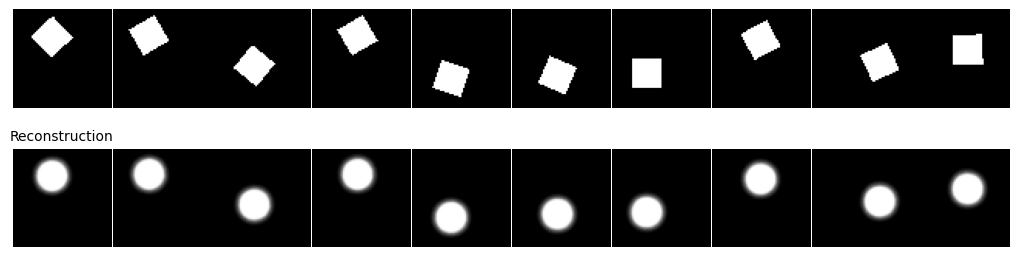

Plotting reconstructions from specific indices...


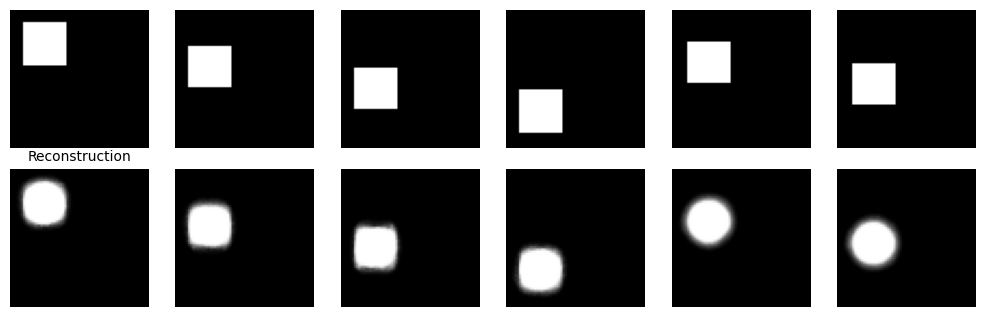

In [11]:
print("Plotting random reconstructions...")
visualizer_g_comm_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_g_comm_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

## Latent Space Traversals

Plotting latent traversals...


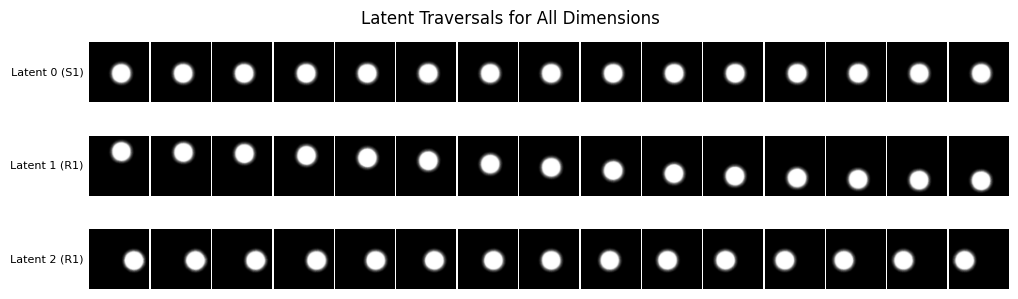

In [12]:
print("Plotting latent traversals...")
visualizer_g_comm_dsprites.plot_all_latent_traversals(num_samples=15,
                                                      r1_max_traversal_type='probability',
                                                      r1_max_traversal=0.95,
                                                      s1_max_traversal_type='fraction',
                                                      s1_max_traversal=1.0,
                                                      use_ref_img=True
                                                      )
plt.show()

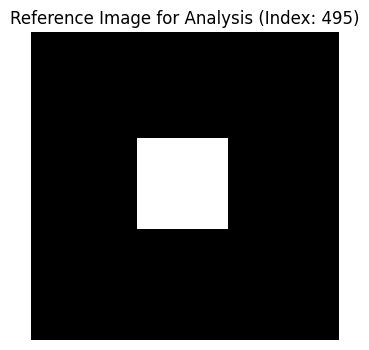

Plotting single latent traversal for dimension 0...


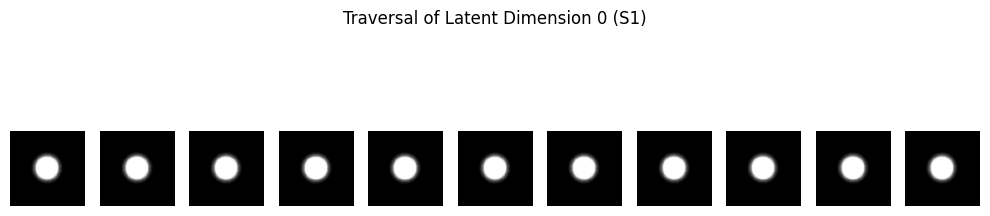

In [13]:
# Select a reference image index for detailed analysis
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.figure(figsize=(4, 4))
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"Reference Image for Analysis (Index: {ref_img_idx_dsprites})")
plt.axis('off')
plt.show()

# Single latent traversal analysis
latent_factor_idx = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx}...")
visualizer_g_comm_dsprites.plot_single_latent_traversal(latent_factor_idx, 
                                                        ref_img=ref_img_dsprites, 
                                                        num_samples=11,
                                                        max_traversal_type='fraction',
                                                        max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


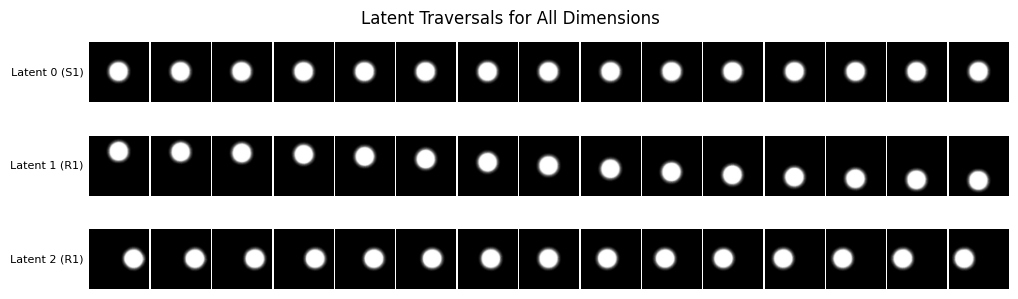

In [14]:
# Complete latent traversal analysis using the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_g_comm_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                                      num_samples=15,
                                                      r1_max_traversal_type='probability',
                                                      r1_max_traversal=0.95,
                                                      s1_max_traversal_type='fraction',
                                                      s1_max_traversal=1
                                                      )
plt.show()